<a href="https://colab.research.google.com/github/Thinsheep/TrainingTrack/blob/main/Traffic_Signs_Starter_Project(Testing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [ ]:
!ls german-traffic-signs # ls to check which files in this folder
# .p mean pickle file, contain serialized data that can be unpick when desired.

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd # use pandas to import data from csv file
import random

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.3.0


In [ ]:
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p','rb') as f: # store all data to f
   train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f: # store all data to f
   val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f: # store all data to f
   test_data = pickle.load(f)

print(type(train_data))
X_train, y_train = train_data['features'], train_data['labels'] # feature: value of training images, 
# label of each image belong to some classes.
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']



<class 'dict'>


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape) # 3 is the depth, 3 color channels

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "This number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "This number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "This number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32x32x3"

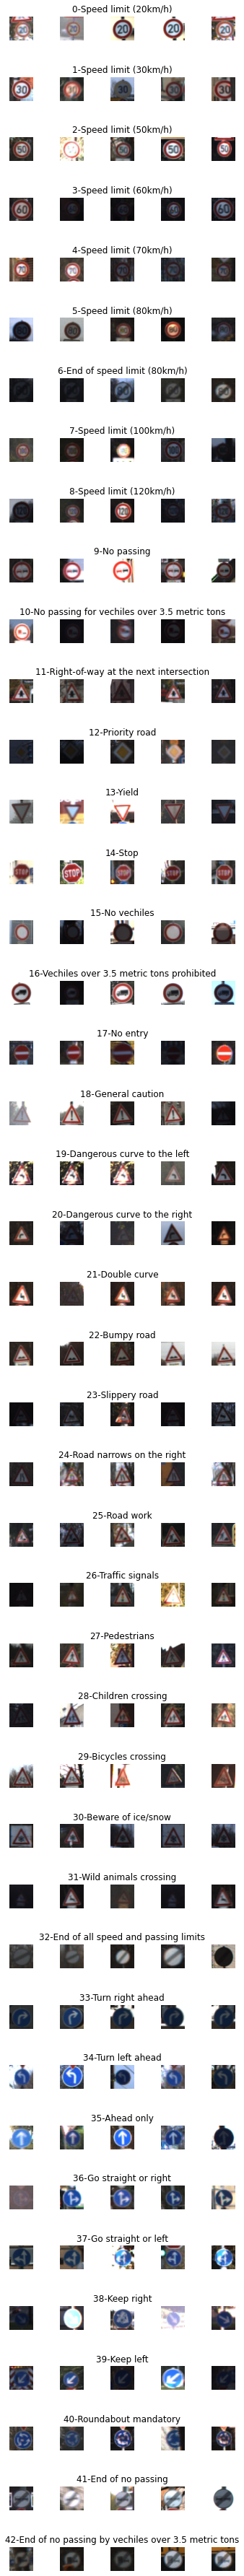

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = [] # recording images and category, each category contain 10 rows of images and 5 colums
cols = 5
num_classes =43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50)) # allow to display multiple 
#plot in the same figure
#5 inches height and 50 inches width whole pic
fig.tight_layout() # dealing with overlappig layout
# now we loop through every colum and everrow
for i in range(cols):
  for j, row in data.iterrows(): # colunm i and row j
      x_selected = X_train[y_train == j] # select the images in the training data
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      # get correct color 
      # first index 0, and last index len() of the array, :: make sure get entire image
      axs[j][i].axis("off")
      if i ==2:
        axs[j][i].set_title(str(j) + "-" + row["SignName"]) # currently we show only 5 samples per class 
        # but accutally we have thousand
        num_of_samples.append(len(x_selected)) # record number of samples of each class appended into a sigle 
        #array, able to multiply
    #(index, Series), series is one dimensional labels

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


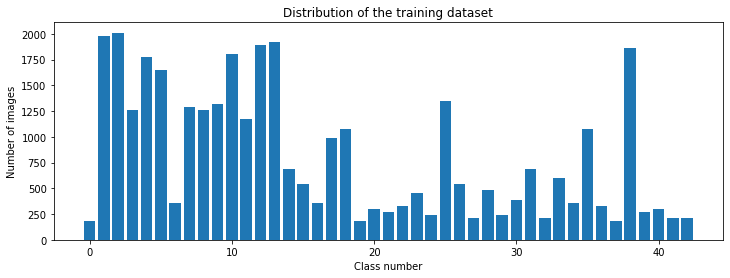

In [ ]:
print(num_of_samples) # amount of images belong to each class
plt.figure(figsize=(12, 4)) # just size of graph
plt.bar(range(0, num_classes), num_of_samples) # attributes for x and y axis
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()
# look like dataset is not completed as some signs only have 180 images

(32, 32, 3)
36


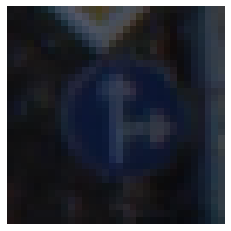

In [ ]:
#as we looking at the images, diffent color, bright condition, we need to 
# preprocess images before training
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000]) # label of class is 36

(32, 32)


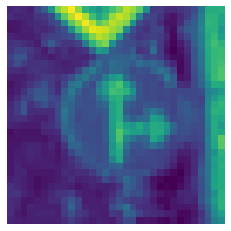

In [ ]:
# Now we move on to the preprocessing technique
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape) # now our image in grayscale so it does not have depth(color)

(32, 32)


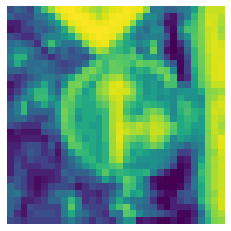

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)# this function is only used for grayscale(not have depth)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)
# it increases contract and more defined features

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255 # this is normalization technique
  return img

X_train = np.array(list(map(preprocessing, X_train))) # this will go through 
#the array (X_train) and update each item, store to the list, then make array
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


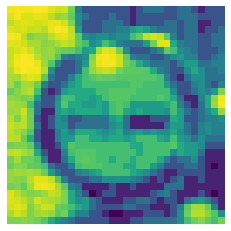

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")# to remove the axis
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                   height_shift_range = 0.1,
                   zoom_range = 0.2,
                   shear_range = 0.1,
                   rotation_range = 10.)
# there will be many tranformation but we focus only 5
datagen.fit(X_train) # help to calculate any statistic needed to perform the 
# transformation of dataset. DataGenerator does not perform for all images in
# the dataset. Only generate the image in the real-time if request. This reduce
# memory requirement but increase time cost during the training.

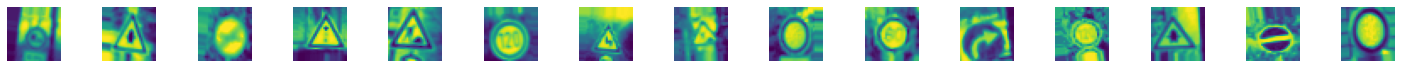

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
# This is to create new images
X_batch, y_batch = next(batches)
# the next function simply calls an iterator item and retrieves the next item for it.
# As we defined our iterator to create a batch size of 20 we get 20 new images each 
# time the next function is called on the iterator.
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [ ]:
y_train = to_categorical(y_train, 43) # one hot encoding
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)
# now we are successfull preprocessing data

In [ ]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape = (32, 32, 1), activation = 'relu'))
  model.add(Conv2D(60, (5,5), activation = 'relu'))

  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(Conv2D(30, (3,3), activation = 'relu'))

  model.add(MaxPooling2D(pool_size = (2,2)))
  #  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))# haft input nodes will be dropped each update
  model.add(Dense(num_classes, activation = 'softmax'))
  # compile model
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model


In [ ]:
model = leNet_model()
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0

In [ ]:
#history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)
training_set = datagen.flow(X_train, y_train, batch_size=50)
validation_set = (X_val, y_val)
history = model.fit(training_set,
                            steps_per_epoch=2000,
                            epochs=10,
                            validation_data= validation_set, shuffle = 1)

Epoch 1/10
 696/2000 [=========>....................] - 11s 16ms/step - loss: 1.7511 - accuracy: 0.5001 - val_loss: 0.3301 - val_accuracy: 0.9041


Text(0.5, 0, 'epoch')

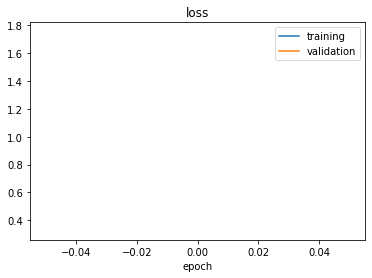

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

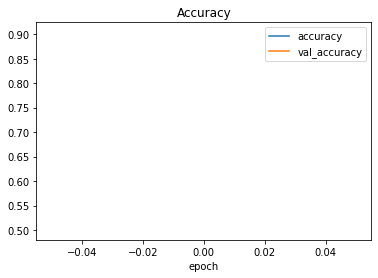

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose= 0)
print(type(score))
print('Test score:', score[0])
print('Test accuracy:', score[1])

<class 'list'>
Test score: 0.3737609088420868
Test accuracy: 0.8882818818092346


<Response [200]>


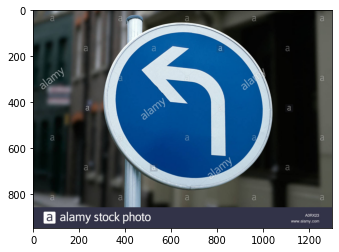

In [ ]:
import requests
from PIL import Image # PIL mean Python Imaging Library
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
response = requests.get(url, stream=True)
print(response)
img =Image.open(response.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


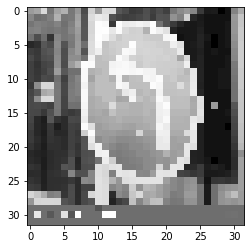

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img = img.reshape(1, 32, 32, 1)

In [ ]:
print("predicted sign:" + str(np.argmax(model.predict(img), axis=-1)))

predicted sign:[5]
